In [1]:
using Pkg
#Pkg.develop("QuantumDots")
Pkg.activate(pwd())
Pkg.instantiate()
using QuantumDots, QuantumDots.BlockDiagonals, LinearAlgebra
using Plots
using Latexify
using LinearSolve # Solving for stationary state
import SymPy # For analytic solutions
import Symbolics

  Activating project at `c:\Users\svens\Projects\QuantumDots.jl\examples`


**Table of contents**<a id='toc0_'></a>    
- [Intro to QuantumDots.jl](#toc1_)    
    - [Defining a basis](#toc1_1_1_)    
    - [Kitaev chain hamiltonian](#toc1_1_2_)    
      - [Diagonalizing the Hamiltonian](#toc1_1_2_1_)    
      - [Majorana quality measures](#toc1_1_2_2_)    
      - [Using SymPy for analytical solutions](#toc1_1_2_3_)    
    - [Optimizing for the sweet spot](#toc1_1_3_)    
    - [Transport](#toc1_1_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Intro to QuantumDots.jl](#toc0_)

### <a id='toc1_1_1_'></a>[Defining a basis](#toc0_)
To specify a basis, define the indices and, optionally, a conserved quantum number


In [2]:
N = 2
d = FermionBasis(1:N, (:↑, :↓); qn=QuantumDots.fermionnumber)

FermionBasis{4,OrderedCollections.OrderedDict{Tuple{Int64, Symbol}, SparseArrays.SparseMatrixCSC{Int64, Int64}},QuantumDots.AbelianFockSymmetry{Vector{Int64}, Dictionaries.Dictionary{Int64, Int64}, Int64, typeof(QuantumDots.fermionnumber)}}:
keys = [(1, :↑), (2, :↑), (1, :↓), (2, :↓)]

The basis allows easy access to the fermionic operators in the many body basis, as well as dictionaries that define how the basis is ordered

In [3]:
d[1,:↑] #is a SparseArray representation of the annihilation operator

16×16 SparseArrays.SparseMatrixCSC{Int64, Int64} with 8 stored entries:
⎡⠈⠀⠠⡀⠀⠀⠀⠀⎤
⎢⠀⠀⠀⠀⠁⢀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠢⠀⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠠⎦

In [4]:
d[N,:↓]' |> Matrix # Creation operator. ' is hermitian conjugate. Use Matrix to convert to dense matrix.

16×16 Matrix{Int64}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0

In [5]:
d[1,:↑]'d[1,:↑] # Number operator 

16×16 SparseArrays.SparseMatrixCSC{Int64, Int64} with 8 stored entries:
⎡⠐⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠀⠐⠄⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠁⢀⠀⠀⎥
⎣⠀⠀⠀⠀⠀⠀⠑⢀⎦

In [6]:
number_operator = sum(f -> f'f, d)
blockdiagonal(number_operator, d) |> blocks .|> display; # Blocks of number operator

1×1 SparseArrays.SparseMatrixCSC{Int64, Int64} with 0 stored entries:
 ⋅

4×4 SparseArrays.SparseMatrixCSC{Int64, Int64} with 4 stored entries:
 1  ⋅  ⋅  ⋅
 ⋅  1  ⋅  ⋅
 ⋅  ⋅  1  ⋅
 ⋅  ⋅  ⋅  1

6×6 SparseArrays.SparseMatrixCSC{Int64, Int64} with 6 stored entries:
 2  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  2  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  2  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  2  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  2  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  2

4×4 SparseArrays.SparseMatrixCSC{Int64, Int64} with 4 stored entries:
 3  ⋅  ⋅  ⋅
 ⋅  3  ⋅  ⋅
 ⋅  ⋅  3  ⋅
 ⋅  ⋅  ⋅  3

1×1 SparseArrays.SparseMatrixCSC{Int64, Int64} with 1 stored entry:
 4

In [7]:
d.symmetry.qntofockstates

5-element Dictionaries.Dictionary{Int64, Vector{Int64}}
 0 │ [0]
 1 │ [1, 2, 4, 8]
 2 │ [3, 5, 6, 9, 10, 12]
 3 │ [7, 11, 13, 14]
 4 │ [15]

In [8]:
d.symmetry.indtofockdict

16-element Vector{Int64}:
  0
  1
  2
  4
  8
  3
  5
  6
  9
 10
 12
  7
 11
 13
 14
 15

In [9]:
pretty_print(rand(4^N), d)

labels = |(1, :↑),(2, :↑),(1, :↓),(2, :↓)>
QN = 0
 |0000> : 0.381
QN = 1
 |1000> : 0.69
 |0100> : 0.4
 |0010> : 0.589
 |0001> : 0.757
QN = 2
 |1100> : 0.855
 |1010> : 0.572
 |0110> : 0.4
 |1001> : 0.505
 |0101> : 0.779
 |0011> : 0.572
QN = 3
 |1110> : 0.346
 |1101> : 0.172
 |1011> : 0.252
 |0111> : 0.15
QN = 4
 |1111> : 0.963


Any quantum number which is diagonal in the fock basis is supported

In [10]:
newqn(focknbr) =
    if iseven(focknbr)
        return :🦄
    else
        if focknbr > 2
            return :👹
        else
            return :🌯
        end
    end
d2 = FermionBasis(1:2; qn=newqn)

FermionBasis{2,OrderedCollections.OrderedDict{Int64, SparseArrays.SparseMatrixCSC{Int64, Int64}},QuantumDots.AbelianFockSymmetry{Vector{Int64}, Dictionaries.Dictionary{Int64, Int64}, Symbol, typeof(newqn)}}:
keys = [1, 2]

In [11]:
pretty_print(rand(4), d2)

labels = |1,2>
QN = 🌯
 |10> : 0.667
QN = 👹
 |11> : 0.511
QN = 🦄
 |00> : 0.202
 |01> : 0.476


In [12]:
pretty_print(rand(4,4), d2)

labels = |12>
QNs = [🌯, 👹, 🦄,]


2-dimensional KeyedArray(NamedDimsArray(...)) with keys:
↓   row ∈ 4-element Vector{QuantumDots.ColoredString{Int64}}
→   col ∈ 4-element Vector{QuantumDots.ColoredString{Int64}}
And data, 4×4 Matrix{Float64}:
            ("|10>")    ("|11>")   ("|00>")     ("|01>")
  ("|10>")   0.496192    0.656608   0.135567     0.842746
  ("|11>")   0.713281    0.45977    0.00798609   0.520803
  ("|00>")   0.411693    0.562816   0.890357     0.334283
  ("|01>")   0.0490651   0.450818   0.837807     0.359436

There is also a free fermion version. Multiplying two BdG fermions gives a BdG matrix.

In [13]:
b = FermionBdGBasis(1:3)

FermionBdGBasis{3, Int64}({1 = 1, 2 = 2, 3 = 3})

In [14]:
b[1] #Annihilation operator, but not a matrix

QuantumDots.BdGFermion{Int64, FermionBdGBasis{3, Int64}, Bool}(1, FermionBdGBasis{3, Int64}({1 = 1, 2 = 2, 3 = 3}), true, true)

In [15]:
b[1]'b[2] - b[1]b[2] + hc # BdG matrix

6×6 SparseArrays.SparseMatrixCSC{Int64, Int64} with 8 stored entries:
 ⋅   1  ⋅   ⋅   1  ⋅
 1   ⋅  ⋅  -1   ⋅  ⋅
 ⋅   ⋅  ⋅   ⋅   ⋅  ⋅
 ⋅  -1  ⋅   ⋅  -1  ⋅
 1   ⋅  ⋅  -1   ⋅  ⋅
 ⋅   ⋅  ⋅   ⋅   ⋅  ⋅

And a Qubit basis:

In [16]:
Q = QuantumDots.QubitBasis(1:N)
Q[1] # Lowering operator of first qubit
Q[1,:X] #X operator acting on the first qubit (X⊗I)

4×4 SparseArrays.SparseMatrixCSC{Int64, Int64} with 4 stored entries:
 ⋅  1  ⋅  ⋅
 1  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  1
 ⋅  ⋅  1  ⋅

### <a id='toc1_1_2_'></a>[Kitaev chain hamiltonian](#toc0_)
We'll implement the interacting Kitaev chain hamiltonian
$$
\begin{equation}
H = \sum_{n = 1}^N \mu c_n^\dagger c_n + \sum_{n=1}^{N-1} (t c_{n+1}^\dagger c_n + \Delta c_{n+1}c_n + \mathrm{h.c}) + V c_{n+1}^\dagger c_{n+1} c_n^\dagger c_n,
\end{equation}
$$
and calculate the energy gap and majorana polarization. We'll use these to tune for a sweet spot where the system has two separated majoranas.

In [17]:
N = 2
c = FermionBasis(1:N, qn=QuantumDots.parity)

Hdot(μ, c) = sum(μ * c[n]'c[n] for n ∈ 1:N)

Hcoup(t, Δ, c) = sum(t * c[n+1]'c[n] + Δ * c[n+1]c[n] + hc for n ∈ 1:N-1)

Hint(V, c) = sum(V * c[n]'c[n]c[n+1]'c[n+1] for n ∈ 1:N-1)

H(μ, t, Δ, V, c=c) = Hdot(μ, c) + Hcoup(t, Δ, c) + Hint(V, c)

cBdG = FermionBdGBasis(1:N)
Hint(V, c::FermionBdGBasis) = first(c)first(c)

Hint (generic function with 2 methods)

In [18]:
SymPy.@syms μ::real t::real Δ::real V::real

(μ, t, Δ, V)

In [19]:
#SymPy.@syms μ::real t::real Δ::real V::real # Define some symbolic variables
Base.promote_op(::Union{typeof(adjoint),typeof(transpose)}, ::Type{T}) where {T<: SymPy.Sym} = T # just to fix a problem with SymPyCore
H(μ, t, Δ, V) #Many body hamiltonian

4×4 SparseArrays.SparseMatrixCSC{SymPyCore.Sym{PyCall.PyObject}, Int64} with 7 stored entries:
 μ  t   ⋅        ⋅
 t  μ   ⋅        ⋅
 ⋅  ⋅   ⋅       -Δ
 ⋅  ⋅  -Δ  V + 2*μ

In [20]:
H(μ, t, Δ, V) |> Matrix |> latexify |> println

\begin{equation}
\left[
\begin{array}{cccc}
\mu & t & 0 & 0 \\
t & \mu & 0 & 0 \\
0 & 0 & 0 &  - \Delta \\
0 & 0 &  - \Delta & V + 2 \cdot \mu \\
\end{array}
\right]
\end{equation}



In [21]:
H(μ, t, Δ, V, cBdG) #BdG hamiltonian

4×4 SparseArrays.SparseMatrixCSC{SymPyCore.Sym{PyCall.PyObject}, Int64} with 12 stored entries:
 μ   t   ⋅   Δ
 t   μ  -Δ   ⋅
 ⋅  -Δ  -μ  -t
 Δ   ⋅  -t  -μ

#### <a id='toc1_1_2_1_'></a>[Diagonalizing the Hamiltonian](#toc0_)

In [22]:
block_eigen(H, c=c) = diagonalize(blockdiagonal(H, c))
ground_states(eigs) = map(eig -> eig.vectors[:,1], blocks(eigs; full=true))
ground_energies(eigs) = map(eig -> eig.values[1], blocks(eigs; full=true))

ground_energies (generic function with 1 method)

#### <a id='toc1_1_2_2_'></a>[Majorana quality measures](#toc0_)
The Majorana Polarization $MP_R$ is a measure of how much the left and right majorana overlap in the region R. The larger it is, the smaller the overlap between the majoranas.
$$\begin{align*}
w_n &= \lang \psi_o | (c_n^\dagger + c_n)  | \psi_e \rang \\
z_n &= \lang \psi_o | (c_n^\dagger - c_n)  | \psi_e \rang \\
MP_R &= \left| \sum_{n \in R} w_n^2 - z_n^2 \right| 
% MP_R &= \frac{\left| \sum_{n \in R} w_n^2 - z_n^2 \right| }{\sum_{n \in R}\left|  w_n \right|^2 + \left| z_n \right|^2}
\end{align*}$$


In [23]:
function MP(ψₒ, ψₑ, R, c=c)
    w = map(f -> ψₒ' * (f' + f) * ψₑ, c)
    z = map(f -> ψₒ' * (f' - f) * ψₑ, c)
    abs(sum(w[n]^2 - z[n]^2 for n ∈ R))# / sum(abs2(w[n]) + abs2(z[n]) for n ∈ R)
end

MP (generic function with 2 methods)

The Local Distinguishability $LD_R$ measures how much the even and odd ground states can be distinguished based on measurements in the region R. 
$$\begin{align*}
\delta \rho &= |\psi_o \rang \lang \psi_o | - |\psi_e \rang \lang \psi_e | \\
LD_R &=  \| \operatorname{Tr}_{R^c}[\delta\rho] \|
\end{align*}$$

In [24]:
function LD(ψₒ, ψₑ, R, c=c)
    δρ = ψₒ*ψₒ' - ψₑ*ψₑ'
    norm(partial_trace(δρ, R, c))
end

LD (generic function with 2 methods)

In [25]:
function fullsolve(μ, t, Δ, V, c=c)
    h = H(μ, t, Δ, V, c)
    eigs = block_eigen(h, c)
    Eₒ, Eₑ = ground_energies(eigs)
    ψₒ, ψₑ = ground_states(eigs)
    R = 1:(length(c)÷2)
    gap = Eₒ - Eₑ
    mp = MP(ψₒ, ψₑ, R, c)
    ld = LD(ψₒ, ψₑ, R, c)
    return (; mp, ld, gap)
end

fullsolve (generic function with 2 methods)

In [26]:
μs = range(-2, 2, length=100)
ts = range(-2, 2, length=100)
data = [fullsolve(μ, t, 1.0, 1.0) for μ in μs, t in ts];

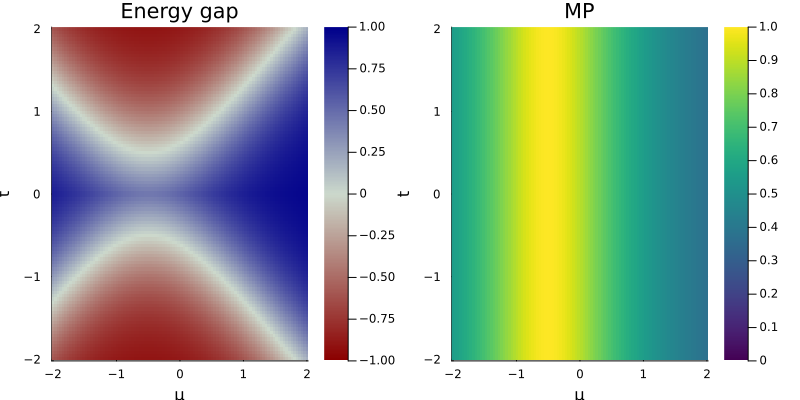

In [27]:
p1 = heatmap(μs, ts, map(x -> tanh(x.gap), data)', xlabel="μ", ylabel="t", title="Energy gap", c=:redsblues, clims=(-1, 1))
p2 = heatmap(μs, ts, map(x -> x.mp, data)', xlabel="μ", ylabel="t", title="MP", c=:viridis, clims=(0, 1))
fig = plot(p1, p2, size=400 .* (2, 1))

#### <a id='toc1_1_2_3_'></a>[Using SymPy for analytical solutions](#toc0_)

In [28]:
function fullsolve(μ::SymPy.Sym, t, Δ, V, c=c)
    h = blockdiagonal(H(μ, t, Δ, V), c)
    ho, he = SymPy.Matrix.(Matrix.(blocks(h)))
    vecs_o, vals_o = ho.diagonalize()
    vecs_e, vals_e = he.diagonalize()
    Ee = diag(vals_e)[1]
    ve = vcat(zero(vecs_e[:, 1]), vecs_e[:, 1])
    Eo = diag(vals_o)[1]
    vo = vcat(vecs_o[:, 1], zero(vecs_o[:, 1]))
    R = 1:length(c)÷2
    return (; mp=MP(vo, ve, R, c), ld=LD(vo, ve, R, c), gap=Eo - Ee)
end

fullsolve (generic function with 4 methods)

In [29]:
SymPy.@syms μ::real t::real Δ::real V::real
foreach(p->(display(p[1]); display(p[2])), pairs(fullsolve(μ, t, Δ, V)))

:mp

|                                             2                                >
|/                 __________________________\    /                 __________ >
||                /  2              2      2 |    |                /  2        >
||    V + 2*μ + \/  V  + 4*V*μ + 4*Δ  + 4*μ  |    |    V + 2*μ + \/  V  + 4*V* >
||1 - ---------------------------------------|  - |1 + ----------------------- >
|\                      2*Δ                  /    \                      2*Δ   >

>                  2|
> ________________\ |
>        2      2 | |
> μ + 4*Δ  + 4*μ  | |
> ----------------| |
>                 / |

:ld

|                                              /          ____________________ >
|    /             __________________________\ |             _________________ >
|    |            /  2              2      2 | |            /  2               >
|    \V + 2*μ + \/  V  + 4*V*μ + 4*Δ  + 4*μ  /*\V + 2*μ + \/  V  + 4*V*μ + 4*Δ >
|1 - ------------------------------------------------------------------------- >
|                                              2                               >
|                                           4*Δ                                >

> _________\|
> _________||
> 2      2 ||
>   + 4*μ  /|
> ----------|
>           |
>           |

:gap

             __________________________
            /  2              2      2 
  V       \/  V  + 4*V*μ + 4*Δ  + 4*μ  
- - - t + -----------------------------
  2                     2              

### <a id='toc1_1_3_'></a>[Optimizing for the sweet spot](#toc0_)
We'll define the sweet spot as the spot where the MP is largest and with an exact energy degeneracy. The optimization problem is
$$
\begin{aligned}
\max_{X} \quad & MP(X)\\
\textrm{s.t.} \quad & \delta E(X) = 0
\end{aligned}
$$ where $X$ denotes the parameters we optimize over.

We can check the documentation of [Optimization.jl](https://github.com/SciML/Optimization.jl) to find, and call to, a suitable package to solve this problem. 

Here, we will use [BlackBoxOptim.jl](https://github.com/robertfeldt/BlackBoxOptim.jl) directly. This package does gradient-free optimization, so we don't have to figure out how to take derivatives. However, it does not support constraints, so we will enforce the constraint by the [Penalty Method](https://en.wikipedia.org/wiki/Penalty_method) where we instead minimize
$$\begin{equation*}
\min_{X} \quad \lambda \delta E(X)^2 - MP(X)
\end{equation*}$$
where $\lambda$ is a large positive number. This will make the optimizer prefer solutions with a smaller energy difference.

In [30]:
#Let's assume that Δ and V are fixed and we optimize over μ and t
function cost(x; Δ=1.0, V=1.0, λ=1e3, c=c)
    μ, t = x
    (; gap, mp, ld) = fullsolve(μ, t, Δ, V, c)
    λ * gap^2 - mp
end

cost (generic function with 1 method)

In [31]:
using BlackBoxOptim
opt = bboptimize(cost; NumDimensions=2)
sweet_spot = best_candidate(opt)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps

Optimization stopped after 10001 steps and 0.20 seconds
Termination reason: Max number of steps (10000) reached
Steps per second = 51025.55
Function evals per second = 52000.04
Improvements/step = 0.30960
Total function evaluations = 10192


Best candidate found: [-0.5, -0.5]

Fitness: -1.000000000



2-element Vector{Float64}:
 -0.49999999843484355
 -0.5000000001578357

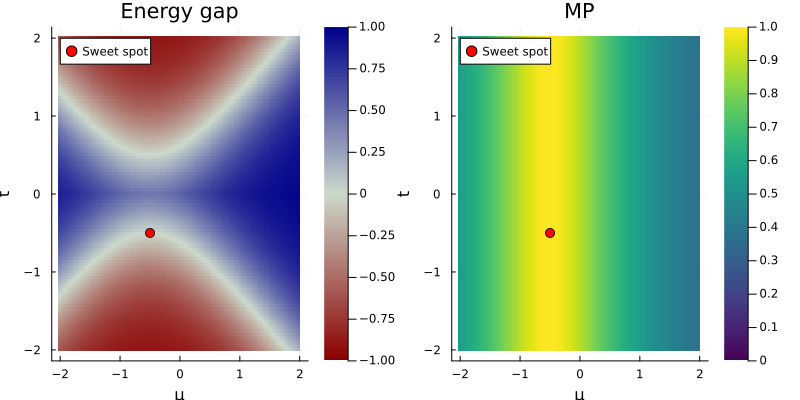

In [32]:
foreach(n -> scatter!(fig[n], [sweet_spot[1]], [sweet_spot[2]], c = :red, markersize = 5, label = "Sweet spot"), 1:2)
fig

### <a id='toc1_1_4_'></a>[Transport](#toc0_)

In [33]:
function get_leads(c, T, μ, Γ=1)
    N = length(c)
    left = QuantumDots.NormalLead(Γ * c[1]'; T, μ=μ[1])
    right = QuantumDots.NormalLead(Γ * c[N]'; T, μ=μ[2])
    return (; left, right)
end

get_leads (generic function with 2 methods)

In [34]:
import AbstractDifferentiation as AD
using ForwardDiff
function conductance(H, T, V1, V2; system=QuantumDots.PauliSystem, ad=AD.ForwardDiffBackend())
    leads = get_leads(c, T, (V1, V2))
    sys = system(H, leads)
    rho = solve(StationaryStateProblem(sys))
    conductance_matrix(ad, sys, rho)
end

conductance (generic function with 1 method)

In [35]:
function fullsolve_transport(μ, t, Δ, V, c=c; V1=0.0, V2=0.0, T=Δ / 40)
    h = H(μ, t, Δ, V, c)
    eigen = block_eigen(h, c)
    Eₒ, Eₑ = ground_energies(eigen)
    ψₒ, ψₑ = ground_states(eigen)
    N = length(c)
    R = 1:N÷2
    mp = MP(ψₒ, ψₑ, R, c)
    ld = LD(ψₒ, ψₑ, R, c)
    gap = Eₒ - Eₑ
    cond = conductance(h, T, V1, V2)
    return (; mp, ld, gap, cond)
end

fullsolve_transport (generic function with 2 methods)

In [36]:
μs = range(-2, 2, length=100)
ts = range(-2, 2, length=100)
data_transport = [fullsolve_transport(μ, t, 1.0, 1.0) for μ in μs, t in ts];

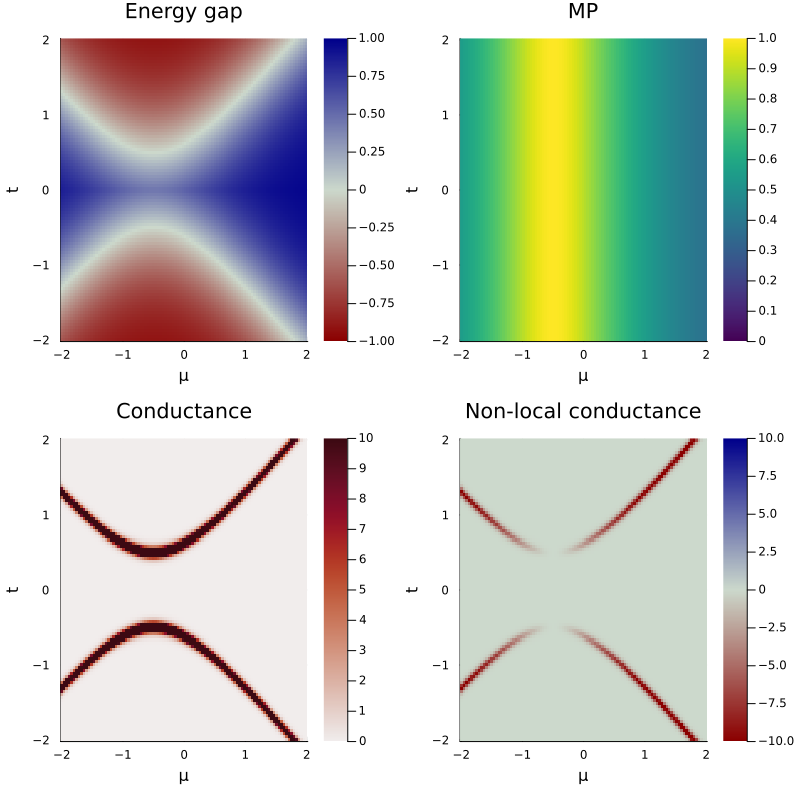

In [37]:
p1 = heatmap(μs, ts, map(x -> tanh(x.gap), data_transport)', xlabel="μ", ylabel="t", title="Energy gap", c=:redsblues, clims=(-1, 1))
p2 = heatmap(μs, ts, map(x -> x.mp, data_transport)', xlabel="μ", ylabel="t", title="MP", c=:viridis, clims=(0, 1))
p3 = heatmap(μs, ts, map(x -> x.cond[1, 1] , data_transport)', xlabel="μ", ylabel="t", title="Conductance", c=:amp, clims=(0, 10))
p4 = heatmap(μs, ts, map(x -> x.cond[1, 2], data_transport)', xlabel="μ", ylabel="t", title="Non-local conductance", c=:redsblues, clims=(-10, 10))
plot(p1, p2, p3, p4, size=400 .* (2, 2))

In [38]:
μs = range(-2, 2, length=100)
bias = range(-4,4, length=100)
@time data_transport_bias = let V = .0
[fullsolve_transport(μ, 1.0- V/2, 1.0, V; V1=bias/2, V2=-bias/2) for μ in μs, bias in bias]
end;
data_transport_bias2 = let V = 1.5
[fullsolve_transport(μ, 1.0- V/2, 1.0, V; V1=bias/2, V2=-bias/2) for μ in μs, bias in bias]
end;

  0.619596 seconds (10.55 M allocations: 577.241 MiB, 8.25% gc time, 7.22% compilation time)


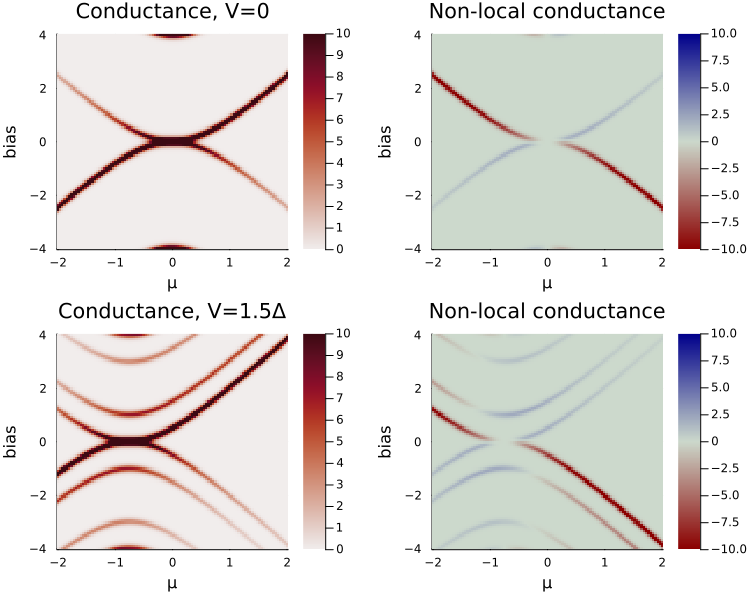

In [39]:
p1 = heatmap(μs, bias, map(x -> x.cond[1, 1], data_transport_bias)', xlabel="μ", ylabel="bias", title="Conductance, V=0", c=:amp, clims=(0, 10))
p2 = heatmap(μs, bias, map(x -> x.cond[1, 2], data_transport_bias)', xlabel="μ", ylabel="bias", title="Non-local conductance", c=:redsblues, clims=(-10, 10))
p3 = heatmap(μs, bias, map(x -> x.cond[1, 1], data_transport_bias2)', xlabel="μ", ylabel="bias", title="Conductance, V=1.5Δ", c=:amp, clims=(0, 10))
p4 = heatmap(μs, bias, map(x -> x.cond[1, 2], data_transport_bias2)', xlabel="μ", ylabel="bias", title="Non-local conductance", c=:redsblues, clims=(-10, 10))
plot(p1, p2, p3, p4, size=300 .* (2.5, 2))